## Initial PoC Notebook
#### Process so far:
- Checking data can be loaded from google drive
- Testing image annotation using keras.preprocessing.image_dataset_from_directory <br> *Note: loads as tf Dataset*
- Working with tf Dataset object (instead of pd DataFrame)
- Annotation from directory resource:<br>
[Keras Image Data Preprocessing ](https://keras.io/api/preprocessing/image/#image_dataset_from_directory-function)
- Model based on Keras tutorial found here: <br>
[Keras Image Classification from Scratch](https://keras.io/examples/vision/image_classification_from_scratch/)

#### Need to:
- Separate test dataset
- Optimise model
- Explore alternative methods such as using OpenFace to annotate "action units" e.g. muscle movements in the face images as outlined in this article: https://towardsdatascience.com/can-you-teach-a-computer-to-see-your-pain-18c0f60eb0e4

In [1]:
#mount google drive 
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [33]:
#folder directory in google drive
data_root='/content/drive/My Drive/DelawarePainDatabase'

In [34]:
# returns train and validation datasets with labels derived from directory names
image_size = (256, 256)
batch_size = 32

data_train = tf.keras.preprocessing.image_dataset_from_directory(
    data_root,
    labels="inferred",
    label_mode="int",
    batch_size=batch_size,
    image_size=image_size,
    seed=1337,
    validation_split=0.2,
    subset="training",
    interpolation="bilinear",
)

data_val = tf.keras.preprocessing.image_dataset_from_directory(
    data_root,
    labels="inferred",
    label_mode="int",
    batch_size=batch_size,
    image_size=image_size,
    seed=1337,
    validation_split=0.2,
    subset="validation",
    interpolation="bilinear",
)

Found 1059 files belonging to 2 classes.
Using 848 files for training.
Found 1059 files belonging to 2 classes.
Using 211 files for validation.


In [35]:
for image_batch, labels_batch in data_train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [36]:
class_names = data_train.class_names
print(class_names)

['0. Neutral', '1. Pain']


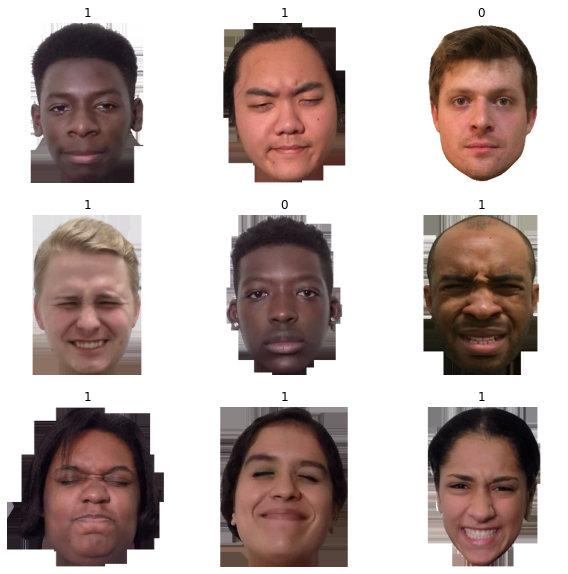

In [37]:
plt.figure(figsize=(10, 10))
for images, labels in data_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


In [38]:
# artificially introduce sample diversity since we have small image dataset
# applies random realistic transformations to training images e.g. horizontal flipping or rotations
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

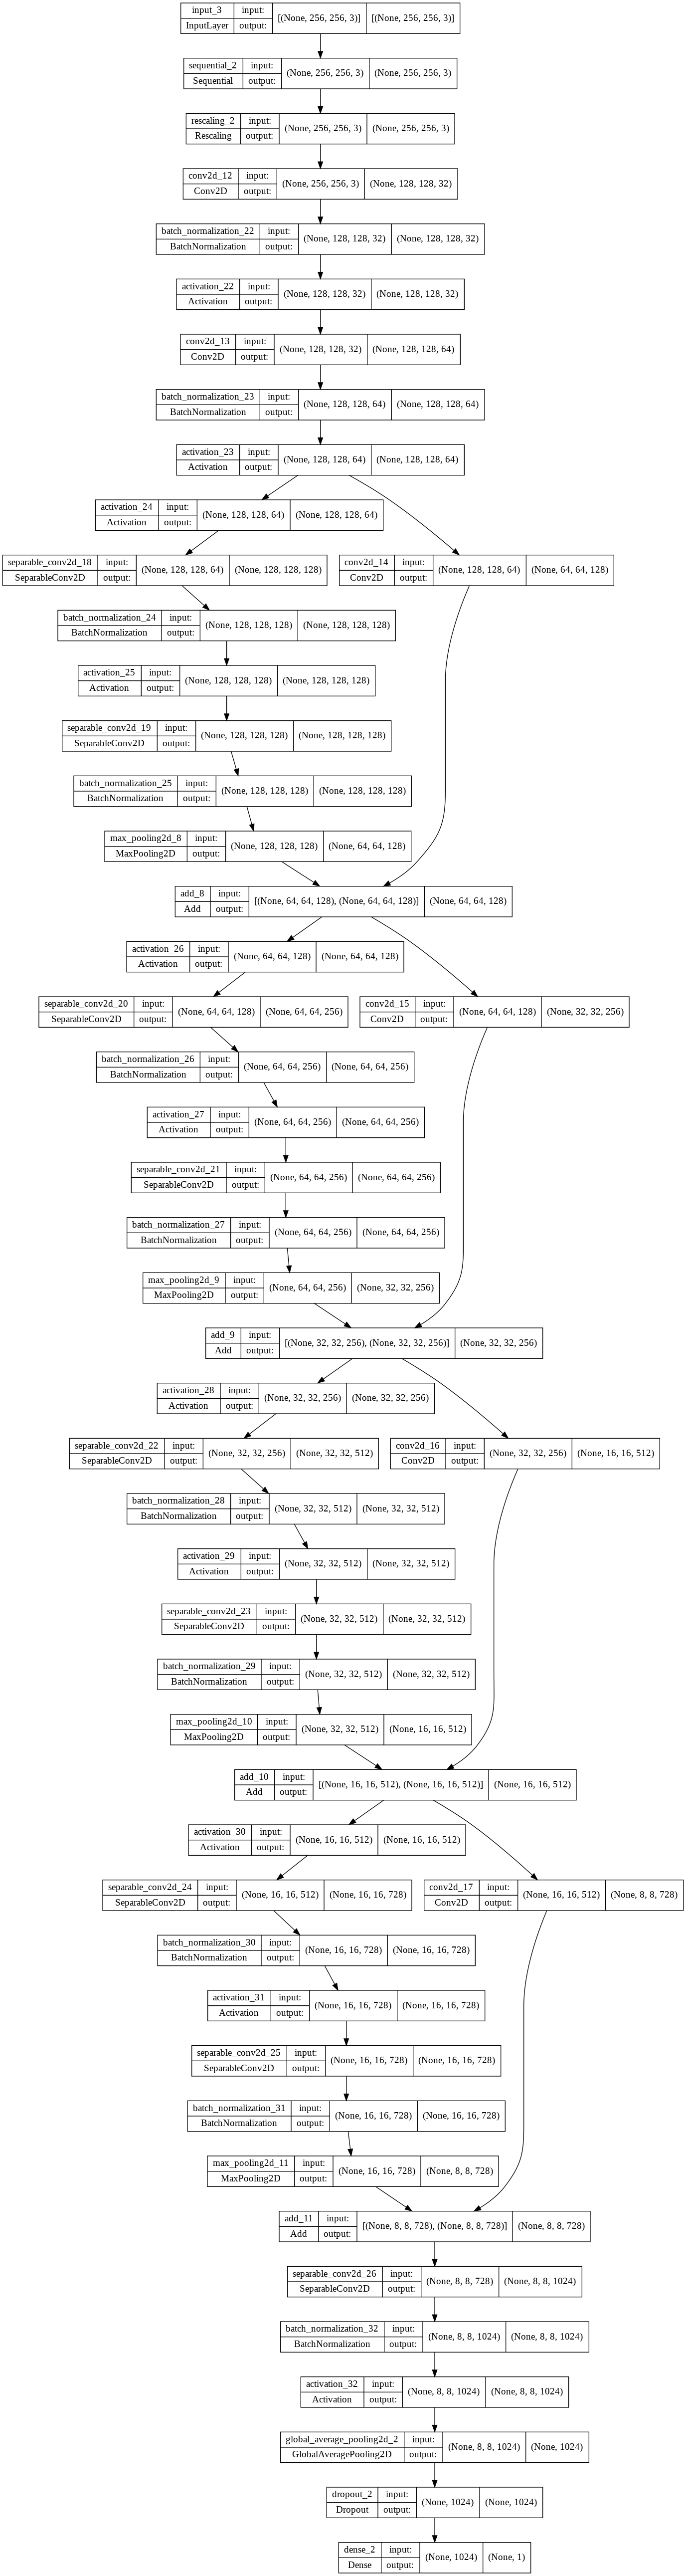

In [39]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


In [40]:
# compile model
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [41]:
# train model
model.fit(
  data_train,
  validation_data=data_val,
  epochs=10)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


27/27 [==============================] - 340s 12s/step - loss: 0.5888 - accuracy: 0.7276 - val_loss: 0.6393 - val_accuracy: 0.7773
Epoch 2/10
27/27 [==============================] - 344s 12s/step - loss: 0.5327 - accuracy: 0.7500 - val_loss: 0.5901 - val_accuracy: 0.7773
Epoch 3/10
27/27 [==============================] - 343s 12s/step - loss: 0.5233 - accuracy: 0.7606 - val_loss: 0.5457 - val_accuracy: 0.7773
Epoch 4/10
27/27 [==============================] - 341s 12s/step - loss: 0.5083 - accuracy: 0.7547 - val_loss: 0.5305 - val_accuracy: 0.7773
Epoch 5/10
27/27 [==============================] - 345s 12s/step - loss: 0.4254 - accuracy: 0.8101 - val_loss: 0.5340 - val_accuracy: 0.7773
Epoch 6/10
27/27 [==============================] - 343s 12s/step - loss: 0.3641 - accuracy: 0.8314 - val_loss: 0.5642 - val_accuracy: 0.7773
Epoch 7/10
27/27 [==============================] - 349s 13s/step - loss: 0.2847 - accuracy: 0.8774 - val_loss: 0.6167 - val_accuracy: 0.7773
Epoch 8/10
27/27 

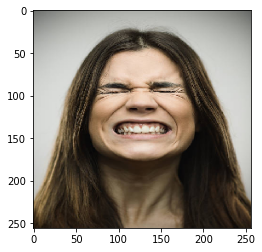

In [46]:
plt.imshow(img)

In [45]:
image_url = "https://2rdnmg1qbg403gumla1v9i2h-wpengine.netdna-ssl.com/wp-content/uploads/sites/3/2019/06/painfulJaw-477695713-770x553-650x428.jpg"
image_path = tf.keras.utils.get_file('man_Pain', origin=image_url)

img = tf.keras.utils.load_img(image_path, target_size=(256, 256))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "I'm %.2f %% confident this expression is neutral and %.2f %% confident it shows pain."
    % (100 * (1 - score), 100 * score)
)


I'm 1.50 % confident this expression is neutral and 98.50 % confident it shows pain.
